In [3]:
%%time

import tensorflow as tf
print(tf.__version__)
import sys
sys.path.append("..")
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np


def plot_loss(history, *losses):
    for loss in losses:
        plt.plot(history.history[loss], label=loss)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

def scaling(x, min, max):
    return np.where(x < min, 0.0, np.where(x > max, 1.0, (x - min) / (max - min)))

early_stopping = EarlyStopping(
    monitor='val_loss',  # 
    patience=500,        # 
    verbose=1,          # 
    mode='min',         # 
    restore_best_weights=True  # 
)

2023-12-03 18:28:22.583094: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-03 18:28:22.649557: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-03 18:28:22.649598: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-03 18:28:22.649653: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-03 18:28:22.662462: I tensorflow/core/platform/cpu_feature_g

2.14.0
CPU times: user 4.07 s, sys: 2.85 s, total: 6.92 s
Wall time: 3.99 s


In [4]:
SAVE_DIR = "../data"
file_criteo = SAVE_DIR + "/criteo-uplift-v2.1.csv"
df_criteo_ori = pd.read_csv(file_criteo, sep=',')

In [5]:
df_criteo_ori.describe()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,treatment,conversion,visit,exposure
count,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07
mean,1.962030e+01,1.006998e+01,8.446582e+00,4.178923e+00,1.033884e+01,4.028513e+00,-4.155356e+00,5.101765e+00,3.933581e+00,1.602764e+01,5.333396e+00,-1.709672e-01,8.500001e-01,2.916680e-03,4.699200e-02,3.063122e-02
std,5.377464e+00,1.047557e-01,2.993161e-01,1.336645e+00,3.433081e-01,4.310974e-01,4.577914e+00,1.205248e+00,5.665958e-02,7.018975e+00,1.682288e-01,2.283277e-02,3.570713e-01,5.392748e-02,2.116217e-01,1.723164e-01
min,1.261636e+01,1.005965e+01,8.214383e+00,-8.398387e+00,1.028053e+01,-9.011892e+00,-3.142978e+01,4.833815e+00,3.635107e+00,1.319006e+01,5.300375e+00,-1.383941e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.261636e+01,1.005965e+01,8.214383e+00,4.679882e+00,1.028053e+01,4.115453e+00,-6.699321e+00,4.833815e+00,3.910792e+00,1.319006e+01,5.300375e+00,-1.686792e-01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.192341e+01,1.005965e+01,8.214383e+00,4.679882e+00,1.028053e+01,4.115453e+00,-2.411115e+00,4.833815e+00,3.971858e+00,1.319006e+01,5.300375e+00,-1.686792e-01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,2.443646e+01,1.005965e+01,8.723335e+00,4.679882e+00,1.028053e+01,4.115453e+00,2.944427e-01,4.833815e+00,3.971858e+00,1.319006e+01,5.300375e+00,-1.686792e-01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,2.674526e+01,1.634419e+01,9.051962e+00,4.679882e+00,2.112351e+01,4.115453e+00,2.944427e-01,1.199840e+01,3.971858e+00,7.529502e+01,6.473917e+00,-1.686792e-01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [6]:
%%time

sample = 0.15
random_state=20220720
df_criteo=df_criteo_ori.sample(frac=sample, random_state=random_state).reset_index(drop=True)
X = df_criteo[['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11']].values

X[:, 0] = scaling(X[:, 0], min=np.min(X[:, 0]), max=np.max(X[:, 0]))
X[:, 1] = scaling(X[:, 1], min=np.min(X[:, 1]), max=np.max(X[:, 1]))
X[:, 2] = scaling(X[:, 2], min=np.min(X[:, 2]), max=np.max(X[:, 2]))
X[:, 3] = scaling(X[:, 3], min=np.min(X[:, 3]), max=np.max(X[:, 3]))
X[:, 4] = scaling(X[:, 4], min=np.min(X[:, 4]), max=np.max(X[:, 4]))
X[:, 5] = scaling(X[:, 5], min=np.min(X[:, 5]), max=np.max(X[:, 5]))
X[:, 6] = scaling(X[:, 6], min=np.min(X[:, 6]), max=np.max(X[:, 6]))
X[:, 7] = scaling(X[:, 7], min=np.min(X[:, 7]), max=np.max(X[:, 7]))
X[:, 8] = scaling(X[:, 8], min=np.min(X[:, 8]), max=np.max(X[:, 8]))
X[:, 9] = scaling(X[:, 9], min=np.min(X[:, 9]), max=np.max(X[:, 9]))
X[:, 10] = scaling(X[:, 10], min=np.min(X[:, 10]), max=np.max(X[:, 10]))
X[:, 11] = scaling(X[:, 11], min=np.min(X[:, 11]), max=np.max(X[:, 11]))

T = df_criteo['treatment'].values.reshape(-1, 1)
Y_visit = df_criteo['visit'].values.reshape(-1, 1)
Y_conv = df_criteo['conversion'].values.reshape(-1, 1)

T.shape, Y_visit.shape, Y_conv.shape


# calculate len
train_len = int(len(X) * 0.70)
cali_len = int(len(X) * 0.05)
test_len = len(X) - train_len - cali_len

# obtain train set
X_train = X[:train_len, :]
T_train = T[:train_len, :]
Y_visit_train = Y_visit[:train_len, :]
Y_conv_train = Y_conv[:train_len, :]

# obtain calibration set
X_cali = X[train_len:train_len+cali_len, :]
T_cali = T[train_len:train_len+cali_len, :]
Y_visit_cali = Y_visit[train_len:train_len+cali_len, :]
Y_conv_cali = Y_conv[train_len:train_len+cali_len, :]

# obtain test set
X_test = X[train_len+cali_len:, :]
T_test = T[train_len+cali_len:, :]
Y_visit_test = Y_visit[train_len+cali_len:, :]
Y_conv_test = Y_conv[train_len+cali_len:, :]

print(train_len, X_train.shape, X_test.shape, len(X), X_cali.shape)

# make covariate shift
# condition_cali = (X_cali[:, 0] > 0.3) & (X_cali[:, 1] < 0.7)
# X_cali = X_cali[condition_cali]
# T_cali = T_cali[condition_cali]
# Y_visit_cali = Y_visit_cali[condition_cali]
# Y_conv_cali = Y_conv_cali[condition_cali]

# condition_test = (X_test[:, 0] > 0.3) & (X_test[:, 1] < 0.7)
# X_test = X_test[condition_test]
# T_test = T_test[condition_test]
# Y_visit_test = Y_visit_test[condition_test]
# Y_conv_test = Y_conv_test[condition_test]

# print(train_len, X_train.shape, X_test.shape, len(X), X_cali.shape)

1467857 (1467857, 12) (524236, 12) 2096939 (104846, 12)
CPU times: user 1.51 s, sys: 12 ms, total: 1.52 s
Wall time: 1.52 s


# TPM-SL method:

### Train model

In [7]:
count = 1

iteration =  1


2023-12-03 18:31:17.957538: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22288 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:32:00.0, compute capability: 8.9
2023-12-03 18:31:22.483075: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fca26812a30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-03 18:31:22.483106: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2023-12-03 18:31:22.490595: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-12-03 18:31:22.549073: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8902
2023-12-03 18:31:22.725296: I ./tensorflow/compiler/jit/device_compiler.h:186] Compile

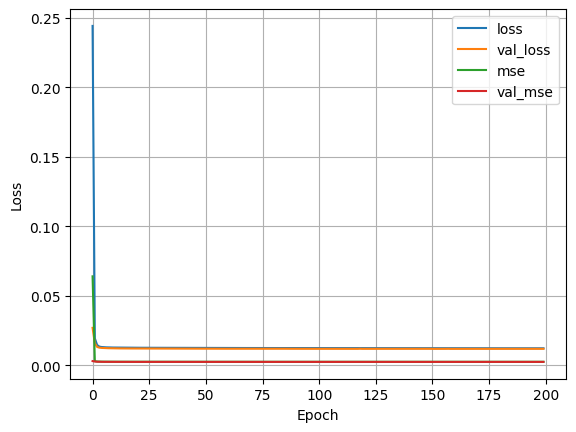

In [ ]:
# S LEARNER MODEL
# Y_conv
# 1e-5
import keras
import keras.backend as K
import tensorflow as tf
from keras.callbacks import LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from model.uplift_model import *

# final_model = get_slearner_criteo_model()
# final_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['mse'])
# #lambda y_true,y_pred: y_pred
# print('trainable_weights')
# for x in final_model.trainable_weights:
#     print(x.name)
# print('non_trainable_weights')
# for x in final_model.non_trainable_weights:
#     print(x.name)
# final_model.summary()


for i in range(count):

    print("iteration = ", i + 1)
    
    final_model = get_slearner_criteo_model()
    final_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['mse'])
    
    mcp_save = ModelCheckpoint('../model_file/roi/criteo/final_model/direct_ratio_SL/c_slearner_criteo_conv_model_{}.h5'.format(i+1), save_best_only=True, monitor='val_loss', mode='min', save_weights_only=True)
    history = final_model.fit([X_train, T_train], Y_conv_train, validation_split=0.2, epochs=200, batch_size=5000, shuffle=True, verbose=0, callbacks=[mcp_save])

    plot_loss(history, "loss", "val_loss", "mse", "val_mse")
    
    final_model = get_slearner_criteo_model()
    final_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['mse'])
    
    mcp_save = ModelCheckpoint('../model_file/uplift/criteo/final_model/slearner/c_slearner_criteo_model_{}.h5'.format(i+1), save_best_only=True, monitor='val_loss', mode='min', save_weights_only=True)
    history = final_model.fit([X_train, T_train], Y_visit_train, validation_split=0.2, epochs=200, batch_size=5000, shuffle=True, verbose=0, callbacks=[mcp_save])

    plot_loss(history, "loss", "val_loss", "mse", "val_mse")
    
    

### predict

iteration =  1
16383/16383 [==============================] - 29s 2ms/step
auc0.9554546381340872
mse0.002364528645978057
16383/16383 [==============================] - 28s 2ms/step


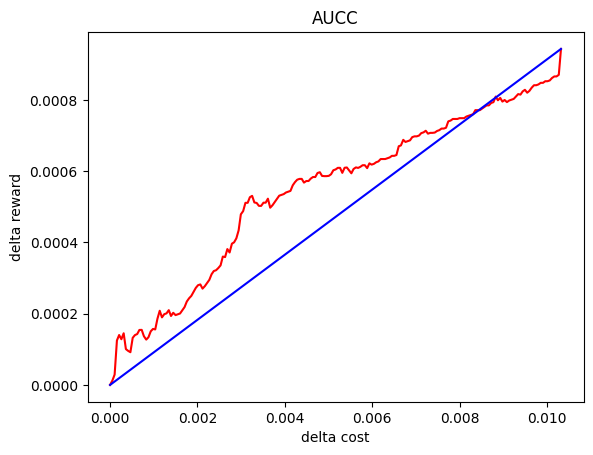

,delta_cost,delta_reward,n_treatment,n_control,roi_pred_treatment,roi_pred_control
0,0.000000,0.000000,0,0,0.000000,0.000000
1,0.000054,0.000012,202,35,183.489868,20.650574
2,0.000104,0.000029,296,45,126.573853,17.024868
3,0.000157,0.000125,784,120,49.688839,8.270991
4,0.000207,0.000140,1071,173,36.957092,6.405919
...,...,...,...,...,...,...
196,0.010114,0.000862,313463,55585,0.239358,0.133722
197,0.010168,0.000866,314788,55824,0.238373,0.133172
198,0.010218,0.000866,315393,55924,0.237925,0.132943
199,0.010270,0.000871,315949,56039,0.237515,0.132680


AUCC =  0.5772202615324253




In [11]:
import sklearn 
import sklearn.metrics
from metric.Metric import *

direct_ratio_SL_aucc_list = []

for i in range(count):
    
    print("iteration = ", i + 1)
    
    final_model = get_slearner_criteo_model()
    final_model.load_weights('../model_file/roi/criteo/final_model/direct_ratio_SL/c_slearner_criteo_conv_model_{}.h5'.format(i+1))
    Y_pre = final_model.predict([X_test, T_test])
    fpr, tpr, thresholds = sklearn.metrics.roc_curve(Y_conv_test, Y_pre)
    print("auc"+str(sklearn.metrics.auc(fpr, tpr)))
    print("mse"+str(sklearn.metrics.mean_squared_error(Y_conv_test, Y_pre)))
    
    
    T0 = np.zeros(shape=T_test.shape)
    T1 = np.ones(shape=T_test.shape)

    p0 = final_model.predict([X_test,  T0])
    p1 = final_model.predict([X_test,  T1])

    slearner_conv_pre = p1 - p0
    
    final_model = get_slearner_criteo_model()
    final_model.load_weights('../model_file/uplift/criteo/final_model/slearner/c_slearner_criteo_model_{}.h5'.format(i+1))
    
    p0 = final_model.predict([X_test,  T0])
    p1 = final_model.predict([X_test,  T1])

    slearner_visit_pre = p1 - p0
    
    
    roi_slearner_pre = slearner_conv_pre / np.where(abs(slearner_visit_pre) < 1e-6, 1e-6, slearner_visit_pre)


    direct_ratio_SL_aucc = get_uplift_model_aucc(t=(T_test > 0.5).flatten(), y_reward=Y_conv_test.flatten(), y_cost=Y_visit_test.flatten(), roi_pred=roi_slearner_pre.flatten(), quantile=200)
    
    direct_ratio_SL_aucc_list.append(direct_ratio_SL_aucc)
    
    print("\n")


In [10]:
# store test aucc for pic 
import pandas as pd

def get_aucc_cost_curve(aucc_list):
    delta_cost_list_group = np.array([aucc[1] for aucc in aucc_list])
    delta_reward_list_group = np.array([aucc[2] for aucc in aucc_list])
    
    avg_delta_cost_list = np.mean(delta_cost_list_group, axis=0)
    avg_delta_reward_list = np.mean(delta_reward_list_group, axis=0)
    
    df_aucc_cost_curve = pd.DataFrame(avg_delta_cost_list, columns=['delta_cost'])
    df_aucc_cost_curve['delta_reward'] = avg_delta_reward_list
    
    return df_aucc_cost_curve

A_direct_ratio_SL_aucc_list = get_aucc_cost_curve(direct_ratio_SL_aucc_list)
print("aucc = ", np.sum(A_direct_ratio_SL_aucc_list['delta_reward'].values) / (A_direct_ratio_SL_aucc_list['delta_reward'].values[-1] * 201))
A_direct_ratio_SL_aucc_list.to_csv("../figure/C_direct_ratio_SL_aucc_list.csv")

aucc =  0.5772202615324253


# TPM-XL method:

### Train model

iteration =  1
45871/45871 [==============================] - 33s 723us/step


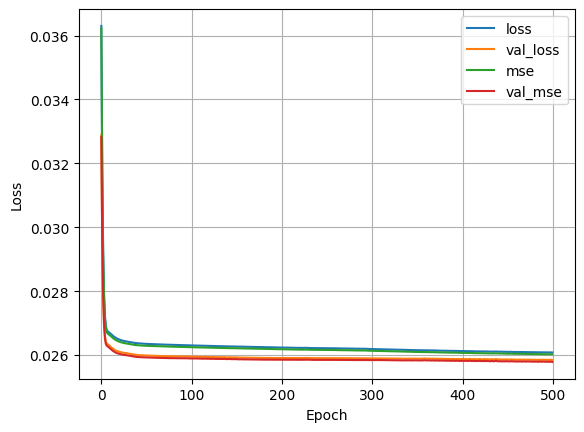

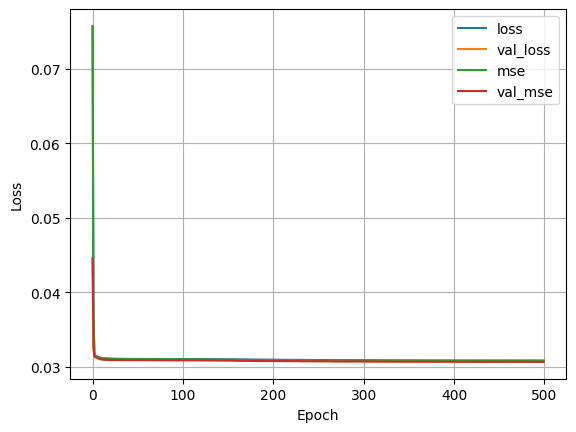

45871/45871 [==============================] - 35s 754us/step


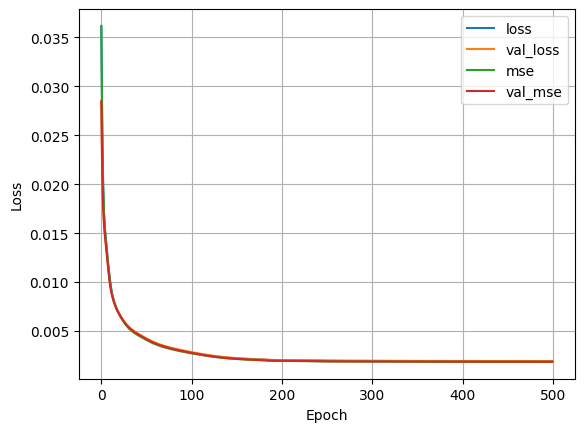

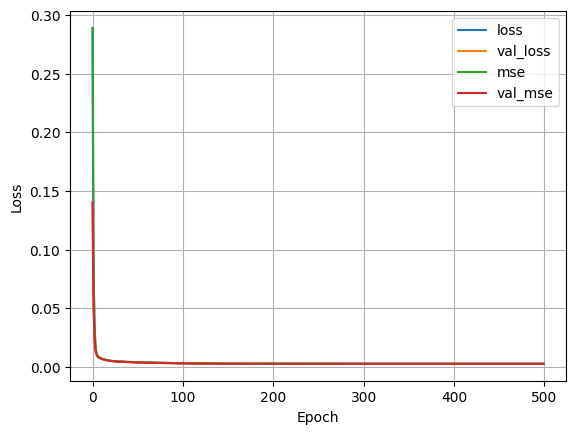

In [9]:
# X LEARNER MODEL
import keras
import keras.backend as K
import tensorflow as tf
from keras.callbacks import LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from model.uplift_model import *

# final_model = get_xlearner_criteo_model()
# final_model.compile(loss='mse', optimizer='adam', metrics=['mse'])
# #lambda y_true,y_pred: y_pred
# print('trainable_weights')
# for x in final_model.trainable_weights:
#     print(x.name)
# print('non_trainable_weights')
# for x in final_model.non_trainable_weights:
#     print(x.name)
# final_model.summary()


for i in range(count):
    
    print("iteration = ", i + 1)
    
    # visit
    final_model = get_slearner_criteo_model()
    final_model.load_weights('../model_file/uplift/criteo/final_model/slearner/c_slearner_criteo_model_{}.h5'.format(i+1))
    T0 = np.zeros(shape=T_train.shape)
    T1 = np.ones(shape=T_train.shape)
    p0 = final_model.predict([X_train,  T0])
    p1 = final_model.predict([X_train,  T1])
    
    X_train_0 = X_train[(T_train.flatten() < 0.5), :]
    X_train_1 = X_train[(T_train.flatten() >= 0.5), :]

    X_train_0_p1_pre = p1[(T_train < 0.5)]
    X_train_1_p0_pre = p0[(T_train >= 0.5)]

    Y_visit_train_0 = Y_visit_train[(T_train < 0.5)]
    Y_visit_train_1 = Y_visit_train[(T_train >= 0.5)]

    tau_0_label = X_train_0_p1_pre - Y_visit_train_0
    tau_1_label = Y_visit_train_1 - X_train_1_p0_pre
    
    
    final_model = get_xlearner_criteo_model()
    final_model.compile(loss='mse', optimizer='adam', metrics=['mse'])

    mcp_save = ModelCheckpoint('../model_file/uplift/criteo/final_model/xlearner/c_visit_xlearner_criteo_model_tau_0_{}.h5'.format(i+1), save_best_only=True, monitor='val_loss', mode='min', save_weights_only=True)
    history = final_model.fit(X_train_0, tau_0_label, validation_split=0.2, epochs=500, batch_size=32688, shuffle=True, verbose=0, callbacks=[mcp_save])

    plot_loss(history, "loss", "val_loss", "mse", "val_mse")
    
    
    final_model = get_xlearner_criteo_model()
    final_model.compile(loss='mse', optimizer='adam', metrics=['mse'])

    mcp_save = ModelCheckpoint('../model_file/uplift/criteo/final_model/xlearner/c_visit_xlearner_criteo_model_tau_1_{}.h5'.format(i+1), save_best_only=True, monitor='val_loss', mode='min', save_weights_only=True)
    history = final_model.fit(X_train_1, tau_1_label, validation_split=0.2, epochs=500, batch_size=32688, shuffle=True, verbose=0, callbacks=[mcp_save])

    plot_loss(history, "loss", "val_loss", "mse", "val_mse")
    
    # conv
    
    final_model = get_slearner_criteo_model()
    final_model.load_weights('../model_file/uplift/criteo/final_model/slearner/c_slearner_criteo_model_{}.h5'.format(i+1))
    T0 = np.zeros(shape=T_train.shape)
    T1 = np.ones(shape=T_train.shape)
    p0 = final_model.predict([X_train,  T0])
    p1 = final_model.predict([X_train,  T1])
    
    X_train_0 = X_train[(T_train.flatten() < 0.5), :]
    X_train_1 = X_train[(T_train.flatten() >= 0.5), :]

    X_train_0_p1_pre = p1[(T_train < 0.5)]
    X_train_1_p0_pre = p0[(T_train >= 0.5)]

    Y_conv_train_0 = Y_conv_train[(T_train < 0.5)]
    Y_conv_train_1 = Y_conv_train[(T_train >= 0.5)]

    tau_0_label = X_train_0_p1_pre - Y_conv_train_0
    tau_1_label = Y_conv_train_1 - X_train_1_p0_pre
    
    
    final_model = get_xlearner_criteo_model()
    final_model.compile(loss='mse', optimizer='adam', metrics=['mse'])

    mcp_save = ModelCheckpoint('../model_file/uplift/criteo/final_model/xlearner/c_conv_xlearner_criteo_model_tau_0_{}.h5'.format(i+1), save_best_only=True, monitor='val_loss', mode='min', save_weights_only=True)
    history = final_model.fit(X_train_0, tau_0_label, validation_split=0.2, epochs=500, batch_size=32688, shuffle=True, verbose=0, callbacks=[mcp_save])

    plot_loss(history, "loss", "val_loss", "mse", "val_mse")
    
    
    final_model = get_xlearner_criteo_model()
    final_model.compile(loss='mse', optimizer='adam', metrics=['mse'])

    mcp_save = ModelCheckpoint('../model_file/uplift/criteo/final_model/xlearner/c_conv_xlearner_criteo_model_tau_1_{}.h5'.format(i+1), save_best_only=True, monitor='val_loss', mode='min', save_weights_only=True)
    history = final_model.fit(X_train_1, tau_1_label, validation_split=0.2, epochs=500, batch_size=32688, shuffle=True, verbose=0, callbacks=[mcp_save])

    plot_loss(history, "loss", "val_loss", "mse", "val_mse")
    
    print("\n")
    


### Predict

iteration =  1
16383/16383 [==============================] - 12s 709us/step


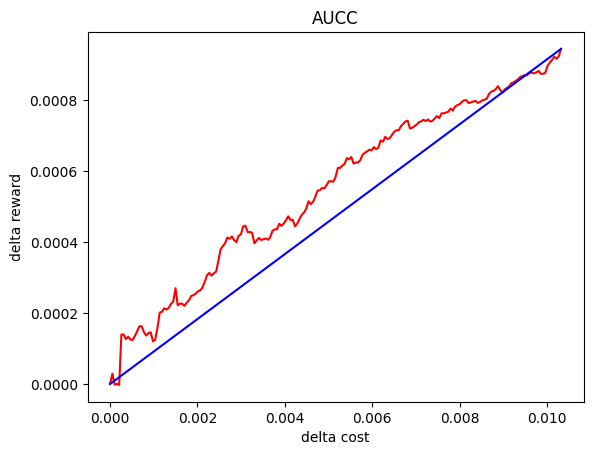

,delta_cost,delta_reward,n_treatment,n_control,roi_pred_treatment,roi_pred_control
0,0.000000,0.000000e+00,0,0,0.000000,0.000000
1,0.000053,2.919879e-05,8948,1674,431.362183,439.723816
2,0.000105,-2.031950e-06,11891,2180,339.645050,351.739227
3,0.000155,2.141109e-07,12289,2241,330.363007,343.608337
4,0.000209,-2.637896e-06,16949,3066,251.897369,263.260895
...,...,...,...,...,...,...
196,0.010116,9.125877e-04,193327,33609,28.744276,30.852695
197,0.010168,9.217860e-04,393693,69658,9.410376,10.117246
198,0.010219,9.158679e-04,403792,71480,8.755333,9.431285
199,0.010270,9.226061e-04,409777,72526,8.350005,9.021437


AUCC =  0.5797103077295622




In [10]:
import sklearn 
import sklearn.metrics

direct_ratio_XL_aucc_list = []

for i in range(count):
    
    print("iteration = ", i + 1)
    
    # conv
    final_model = get_xlearner_criteo_model()
    final_model.load_weights('../model_file/uplift/criteo/final_model/xlearner/c_conv_xlearner_criteo_model_tau_0_{}.h5'.format(i+1))

    tau_0_pre = final_model.predict(X_test)

    final_model = get_xlearner_criteo_model()
    final_model.load_weights('../model_file/uplift/criteo/final_model/xlearner/c_conv_xlearner_criteo_model_tau_1_{}.h5'.format(i+1))

    tau_1_pre = final_model.predict(X_test)

    ex = 0.85
    
    xlearner_conv_pre = ex * tau_0_pre + (1 - ex) * tau_1_pre

#     xlearner_causalml_auuc = get_causalml_auuc(Y=Y_visit_test, T=T_test, ite_pred=xlearner_tau_pre)
    
#     xlearner_causalml_auuc_list.append(xlearner_causalml_auuc)
    # visit
    final_model = get_xlearner_criteo_model()
    final_model.load_weights('../model_file/uplift/criteo/final_model/xlearner/c_visit_xlearner_criteo_model_tau_0_{}.h5'.format(i+1))

    tau_0_pre = final_model.predict(X_test)

    final_model = get_xlearner_criteo_model()
    final_model.load_weights('../model_file/uplift/criteo/final_model/xlearner/c_visit_xlearner_criteo_model_tau_1_{}.h5'.format(i+1))

    tau_1_pre = final_model.predict(X_test)

    ex = 0.85
    
    xlearner_visit_pre = ex * tau_0_pre + (1 - ex) * tau_1_pre
    
    
    # roi
    
    roi_xlearner_pre = xlearner_conv_pre / np.where(abs(xlearner_visit_pre) < 1e-6, 1e-6, xlearner_visit_pre)


    direct_ratio_XL_aucc = get_uplift_model_aucc(t=(T_test > 0.5).flatten(), y_reward=Y_conv_test.flatten(), y_cost=Y_visit_test.flatten(), roi_pred=roi_xlearner_pre.flatten(), quantile=200)
    
    direct_ratio_XL_aucc_list.append(direct_ratio_XL_aucc)
    
    print("\n")

In [11]:
A_direct_ratio_XL_aucc_list = get_aucc_cost_curve(direct_ratio_XL_aucc_list)
print("aucc = ", np.sum(A_direct_ratio_XL_aucc_list['delta_reward'].values) / (A_direct_ratio_XL_aucc_list['delta_reward'].values[-1] * 201))
A_direct_ratio_XL_aucc_list.to_csv("../figure/C_direct_ratio_XL_aucc_list.csv")

aucc =  0.5797103077295622
